In [ ]:
#Mounting on co-lab #comment below two lines of codes for the local execution
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/XD2_Net_Rep') # change folder name for local execution

Mounted at /content/drive


In [ ]:
!pip install pacmap --quiet

     |████████████████████████████████| 647 kB 37.5 MB/s 


In [ ]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pacmap


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *

### Experiment

In [ ]:
#Experimental parameters
prediction = 'Outcome' 
experiment =  'AG' 
exp = 'EXP_2'


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/XD2_Net_Rep" # change folder name for local execution
MILESTONE_DIR = "/content/drive/My Drive/XD2_Net_Rep/"+'/'+experiment+'/' # change folder name for local execution


log = 'BPIC_2017'

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2017_OUTCOME.csv')
log_name = 'BPIC_2017'


#saving parameters to a dictionary
args = get_parameters(MILESTONE_DIR, MY_WORKSPACE_DIR, prediction, experiment, file_name, log_name,exp)

### Evaluation of Model Explanations

In [ ]:
#files

#model explanations
file_explanations = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_explanations.csv')

#LR explanations
file_explanations_LR = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_LR_explanations.csv'))

#DL explanations
file_explanations_DL = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_DL_explanations.csv'))

#loading dataframes

#model explanations
df_explanations = pd.read_csv(file_explanations).reset_index(drop = True)
df_explanations = df_explanations.iloc[:,1:]

#LR explanations
df_explanations_LR = pd.read_csv(file_explanations_LR).reset_index(drop = True)
df_explanations_LR = df_explanations_LR.iloc[:,1:]

#DL explanations
df_explanations_DL = pd.read_csv(file_explanations_DL).reset_index(drop = True)
df_explanations_DL = df_explanations_DL.iloc[:,1:]



In [ ]:
#Choose the model with the best performance for model-x

best_model = '1_10'

df_explanations = df_explanations.loc[df_explanations['BUCKET'] == best_model]
df_explanations_LR = df_explanations_LR.loc[df_explanations_LR['BUCKET'] == best_model]
df_explanations_DL = df_explanations_DL.loc[df_explanations_DL['BUCKET'] == best_model]


#### Support Functions

Format the feature values and feature weights (explanations) into a 2D vector for clustering

In [ ]:
def reformat_exp(df):
  case_num = df['CASEID'].nunique()
  feat_num = int(len(df)/case_num)

  feat_val = np.asarray(df['FEATURE_VALUE']).reshape(case_num,feat_num)
  feat_wgt = np.asarray(df['FEATURE_IMPORTANCE']).reshape(case_num,feat_num)
  cases = np.asarray(df['CASEID'].unique())

  return feat_val,feat_wgt,cases


Get the Optimal Clusters

In [ ]:
def opt_clusters (feat_arr, k):
  Sum_of_squared_distances = []
  K = range(1,k)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(feat_val)
    Sum_of_squared_distances.append(kmeans.inertia_)
  plt.plot(K,Sum_of_squared_distances,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Sum of squared distances/Inertia') 
  plt.title('Elbow Method For Optimal k')
  plt.show()

Get the cluster matrix to show the correlation between feature and explanation patterns

In [ ]:
def cluster_matrix(feat_clusters,exp_clusters):
  # confusion matrix (assymetric)
  fc = np.unique(feat_clusters)
  n = fc.shape[0]
  ec = np.unique(exp_clusters)
  m = ec.shape[0]

  df_q = pd.DataFrame({'feat_clusters':feat_clusters, 'exp_clusters':exp_clusters} )

  cm = []
  for f in fc:
    cm_f = []
    df_temp = df_q[df_q['feat_clusters'] == f]
    for e in ec:
      x = len(df_temp[df_temp['exp_clusters'] == e])
      cm_f = np.append(cm_f,x)
    cm = np.append(cm,cm_f)
  cm = np.reshape(cm,(n,m))

 #Visualizing the confusion matrix

  
  df_cm = pd.DataFrame(cm.astype(int), index = [i for i in range(n)],
                  columns = [i for i in range(m)])
  plt.figure(figsize = (10,7))
  ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap = sn.cubehelix_palette(start=.5, rot=-.7, as_cmap=True))
  plt.xlabel('Explanation Cluster', fontsize = 15) # x-axis label with fontsize 15
  plt.ylabel('Feature Cluster', fontsize = 15) # y-axis label with fontsize 15
  plt.show()

  return cm

Explanation Exclusivity

In [ ]:
def exp_exclusivity(cm,n):

  feat_cl = []
  vol = []
  common_exp = []
  excl = []

  for i in range(n):
    j = cm[i].argmax()
    sum_cl = cm[i].sum()
    sum_cl_exp = cm.T[j].sum()

    exp_rec = cm[i][j]/sum_cl
    exp_prec = cm[i][j]/cm.T[j].sum()
    f1_exp = 2*(exp_rec*exp_prec)/(exp_rec+exp_prec)

    jac_exp = cm[i][j]/(sum_cl+sum_cl_exp-cm[i][j])

    feat_cl.append(i)
    vol.append(sum_cl)
    common_exp.append(j)
    excl.append(jac_exp)

    

  temp_dict = {'Feature cluster':feat_cl, 'Cases':vol, 'Correlated Explanation':common_exp, 'Explanation Correlation':excl  }
  df_exc = pd.DataFrame(temp_dict)

  return df_exc

#### Explanation Evaluation - Explanation Correlation

In [ ]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

In [ ]:
feat_val,feat_wgt,cases = reformat_exp(df_explanations)
feat_val_DL,feat_wgt_DL,cases_DL = reformat_exp(df_explanations_DL)

##### Model-x

In [ ]:
opt_clusters (feat_val, 10) #identify the optimal number of clusters based on the elbow bend

In [ ]:
opt_clusters (feat_wgt, 10) #identify the optimal number of clusters based on the elbow bend

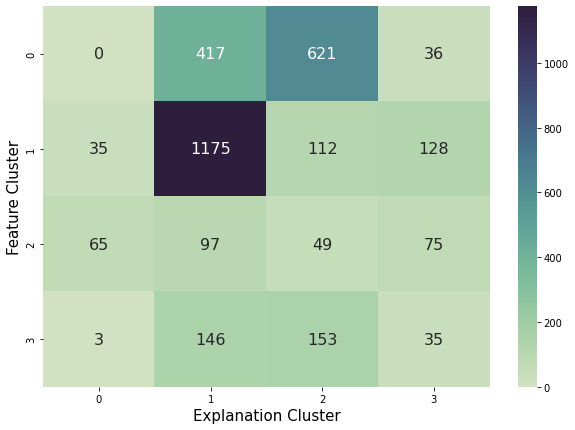

In [ ]:
#clustering the cases based on feature values
n = 4
kmeans_feat = KMeans(n_clusters = n, random_state = 0).fit(feat_val)
feat_clusters = kmeans_feat.labels_

#clustering the cases based on feature weights
m = 4
kmeans_exp = KMeans(n_clusters = m, random_state = 0).fit(feat_wgt)
exp_clusters = kmeans_exp.labels_

cm = cluster_matrix(feat_clusters,exp_clusters)

In [ ]:
df_exc = exp_exclusivity(cm,n)
df_exc

In [ ]:
df_clusters = pd.DataFrame({"CASEID": cases, 'FEAT_CLUSTER':feat_clusters,'EXP_CLUSTER': exp_clusters} )
df_explanations = df_explanations.merge(df_clusters, on = 'CASEID')

In [ ]:
df_explanations = df_explanations[['CASEID', 'BUCKET',
       'FEATURE', 'FEATURE_VALUE', 'FEATURE_IMPORTANCE', 'FEAT_CLUSTER',
       'EXP_CLUSTER']]
df_explanations.head()

In [ ]:
exp_file = os.path.join(MY_WORKSPACE_DIR,os.path.join(exp,log_name+'_explanation_clusters.csv'))
df_explanations.to_csv(exp_file, index = False)

###### Visualize the Explanations - Global Explanations

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(35,7))

medianprops_1 = dict(linestyle='-', linewidth=4, color=cluster_colors[5])
boxprops_1 = dict(linestyle='-', linewidth=1, color=cluster_colors[5])
plot_1 = df_explanations.boxplot(column = 'FEATURE_VALUE', by = 'FEATURE',  medianprops= medianprops_1, boxprops = boxprops_1,fontsize=18, rot = 90 ,showfliers=False, grid = False, ax = axes[0])
plot_1.set_title('Feature Characteristics: overall dataset ',fontsize=20)
plot_1.set_ylabel('Feature value',fontsize=18)
plot_1.set_xlabel('Feature',fontsize=18)
plot_1.set_ylim([-1, 10])

medianprops_2 = dict(linestyle='-', linewidth=4, color=cluster_colors[1])
boxprops_2 = dict(linestyle='-', linewidth=1, color=cluster_colors[1])
plot_2 = df_explanations.boxplot(column = 'FEATURE_IMPORTANCE', by = 'FEATURE',  medianprops= medianprops_2, boxprops = boxprops_2,fontsize=18, rot = 90 , showfliers=False, grid= False, ax = axes[1])
plot_2.set_title('Global Explanation',fontsize=20)
plot_2.set_ylabel('Feature weight',fontsize=18)
plot_2.set_xlabel('Feature',fontsize=18)
plot_2.set_ylim([-1, 10])

fig.suptitle('')


###### Visualization of Each Explanation Cluster

In [ ]:
for i in range(n):
  fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(35,7))
  df_t1 = df_explanations.loc[(df_explanations['FEAT_CLUSTER'] == i) ]  

  #most common explanation
  j = cm[i].argmax()
  df_t2 = df_t1[df_t1['EXP_CLUSTER'] == j]

  medianprops_1 = dict(linestyle='-', linewidth=4, color=cluster_colors[5])
  boxprops_1 = dict(linestyle='-', linewidth=1, color=cluster_colors[5])
  plot_1 = df_t1.boxplot(column = 'FEATURE_VALUE', by = 'FEATURE',  medianprops= medianprops_1, boxprops = boxprops_1,fontsize=18, rot = 90 ,showfliers=False, grid = False, ax = axes[0])
  plot_1.set_title('Feature Cluster Characteristics: Cluster {}'.format(i),fontsize=20)
  plot_1.set_ylabel('Feature value',fontsize=18)
  plot_1.set_xlabel('Feature',fontsize=18)
  plot_1.set_ylim([-1, 10])

  medianprops_2 = dict(linestyle='-', linewidth=4, color=cluster_colors[1])
  boxprops_2 = dict(linestyle='-', linewidth=1, color=cluster_colors[1])
  plot_2 = df_t2.boxplot(column = 'FEATURE_IMPORTANCE', by = 'FEATURE',  medianprops= medianprops_2, boxprops = boxprops_2,fontsize=18, rot = 90 , showfliers=False, grid= False, ax = axes[1])
  plot_2.set_title('Most Common Explanation',fontsize=20)
  plot_2.set_ylabel('Feature weight',fontsize=18)
  plot_2.set_xlabel('Feature',fontsize=18)
  plot_2.set_ylim([-1, 10])

  fig.suptitle('')





###### Visualization of Clusters on 2D space

In [ ]:
#Feature values

#initializing the pacmap instance
# Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
feat_tx = embedding.fit_transform(feat_val, init="pca")

# add the feat clusters as the third column
feat_tx =  np.column_stack((feat_tx,feat_clusters))


#Explanations (Feature weights)

#initializing the pacmap instance
# Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
embedding_2 = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
exp_tx = embedding_2.fit_transform(feat_wgt, init="pca")

# add the feat clusters as the third column
exp_tx =  np.column_stack((exp_tx,feat_clusters,exp_clusters))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

for cl in range(n):
  
  a = feat_tx[np.in1d(feat_tx[:,2],cl)]
  ax.scatter(a[:,0],
                a[:,1],
                color=cluster_colors[cl],
                label='cluster %s' % cl,
                alpha=0.9,
                marker='.'
                )

ax.set_title("PACMAP Visualization \n of feature clusters")
labels = ["cluster "+str(l) for l in range(m)]
fig.legend(labels, loc='lower left',ncol=1, fontsize= 'x-small',bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

for cl in range(n):

  exp_cl = df_exc['Correlated Explanation']
  
  a = exp_tx[np.in1d(exp_tx[:,2],cl)]
  b = a[np.in1d(a[:,3],exp_cl[cl])]
  ax.scatter(b[:,0],
                b[:,1],
                color=cluster_colors[cl],
                label='explanation cluster %s' % exp_cl[cl],
                alpha=0.9,
                marker='.'
                )

ax.set_title("PACMAP Visualization of most common \n explanation cluster for each feature cluster")
labels = ["most common explanation cluster for feature cluster "+str(l) for l in range(n)]
fig.legend(labels, loc='lower left',ncol=1, fontsize= 'x-small',bbox_to_anchor=(1, 0.5))
plt.show()

##### Deep Learning Model (Attention weight based explanation)

In [ ]:
opt_clusters (feat_val_DL, 10) #identify the optimal number of clusters based on the elbow bend

In [ ]:
opt_clusters (feat_wgt_DL, 10) #identify the optimal number of clusters based on the elbow bend

In [ ]:
#clustering the cases based on feature values
n = 4
kmeans_feat = KMeans(n_clusters = n, random_state = 0).fit(feat_val_DL)
feat_clusters_DL = kmeans_feat.labels_

#clustering the cases based on feature weights
m = 4
kmeans_exp = KMeans(n_clusters = m, random_state = 0).fit(feat_wgt_DL)
exp_clusters_DL = kmeans_exp.labels_

cm_DL = cluster_matrix(feat_clusters_DL,exp_clusters_DL)

In [ ]:
df_exc_DL = exp_exclusivity(cm_DL,n)
df_exc_DL

In [ ]:
df_clusters_DL = pd.DataFrame({"CASEID": cases_DL, 'FEAT_CLUSTER':feat_clusters_DL,'EXP_CLUSTER': exp_clusters_DL} )
df_explanations_DL = df_explanations_DL.merge(df_clusters_DL, on = 'CASEID')




In [ ]:
#Plotting the feature weights in deep learning model
plt.hist(df_explanations_DL['FEATURE_IMPORTANCE'])
plt.xlim(xmin=-0.5, xmax = 0.2)

In [ ]:
#removing the non significant features 
df_explanations_DL = df_explanations_DL.loc[abs(df_explanations_DL['FEATURE_IMPORTANCE']) > 0.1]
df_explanations_DL['FEATURE'].nunique()

###### Visualization of Explanation Clusters in 2D space

In [ ]:
#Feature values

#initializing the pacmap instance
# Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
feat_tx_DL = embedding.fit_transform(feat_val_DL, init="pca")

# add the feat clusters as the third column
feat_tx_DL =  np.column_stack((feat_tx_DL,feat_clusters_DL))


#Explanations (Feature weights)

#initializing the pacmap instance
# Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
embedding_2 = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
exp_tx_DL = embedding_2.fit_transform(feat_wgt_DL, init="pca")

# add the feat clusters as the third column
exp_tx_DL =  np.column_stack((exp_tx_DL,feat_clusters_DL,exp_clusters_DL))



In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

for cl in range(n):
  
  a = feat_tx_DL[np.in1d(feat_tx_DL[:,2],cl)]
  ax.scatter(a[:,0],
                a[:,1],
                color=cluster_colors[cl],
                label='cluster %s' % cl,
                alpha=0.9,
                marker='.'
                )

ax.set_title("PACMAP Visualization \n of feature clusters")
labels = ["cluster "+str(l) for l in range(m)]
fig.legend(labels, loc='lower left',ncol=1, fontsize= 'x-small',bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

for cl in range(n):

  exp_cl = df_exc_DL['Correlated Explanation']
  
  a = exp_tx_DL[np.in1d(exp_tx[:,2],cl)]
  b = a[np.in1d(a[:,3],exp_cl[cl])]
  ax.scatter(b[:,0],
                b[:,1],
                color=cluster_colors[cl],
                label='explanation cluster %s' % exp_cl[cl],
                alpha=0.9,
                marker='.'
                )

ax.set_title("PACMAP Visualization of most common \n explanation cluster for each feature cluster")
labels = ["most common explanation cluster for feature cluster "+str(l) for l in range(n)]
fig.legend(labels, loc='lower left',ncol=1, fontsize= 'x-small',bbox_to_anchor=(1, 0.5))
plt.show()



#### Explanation Evaluation - Conciseness

In [ ]:
#Logistic Regression Explanation vs the Global explanation of Model X
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(35,7))

medianprops_1 = dict(linestyle='-', linewidth=6, color=cluster_colors[1])
plot_1 = df_explanations_LR.boxplot(column = 'FEATURE_IMPORTANCE', by = 'FEATURE',  medianprops= medianprops_1, fontsize=18, rot = 90 , showfliers=False, grid= False, ax = axes[0])
plot_1.set_title('Logistic regression explanation', fontsize=20)
plot_1.set_ylabel('Feature weight',fontsize=18)
plot_1.set_xlabel('Feature',fontsize=18)
plot_1.set_ylim([-4, 15])
axes[0].axhline(y=0, color=cluster_colors[4], linestyle='-',linewidth=6)


medianprops_2 = dict(linestyle='-', linewidth=4, color=cluster_colors[1])
boxprops_2 = dict(linestyle='-', linewidth=1, color=cluster_colors[1])
plot_2 = df_explanations.boxplot(column = 'FEATURE_IMPORTANCE', by = 'FEATURE',  medianprops= medianprops_2, boxprops = boxprops_2,fontsize=18, rot = 90 , showfliers=False, grid= False, ax = axes[1])
plot_2.set_title('Global explanation of model-x',fontsize=20)
plot_2.set_ylabel('Feature weight',fontsize=18)
plot_2.set_xlabel('Feature',fontsize=18)
plot_2.set_ylim([-4, 15])
axes[1].axhline(y=0, color=cluster_colors[4], linestyle='-',linewidth=6)


fig.suptitle('')
